In [1]:
## Imports ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.autograd import Variable

import gym
import numpy as np
from itertools import count

import logger 

import pdb 

/home/aashi/penv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
## Environment Declaration ##
env = gym.make('CartPole-v0')
env.seed(0)
torch.manual_seed(0)
gamma = 0.99 
eps = np.finfo(np.float32).eps.item() 
## for removing numerical instability
global_step = 0 
tb_folder = './sample_efficiency_2'
tb = logger.Logger(tb_folder, name='freeloc') 

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
## Policy Network ## 
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(4, 8)
        self.affine2 = nn.Linear(8, 2)
        
        self.saved_log_probs = []
        self.rewards = []
        
        self.policy_file = './policy_model'
        
    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.affine2(x)
        return F.softmax(action_scores, dim=1)
    
    def save_model_weights(self):
        torch.save(self.state_dict(), self.policy_file)

    def load_model_weights(self):
        checkpoint_dict = torch.load(self.policy_file)
        self.load_state_dict(checkpoint_dict)

In [4]:
## Select action based on policy network ## 
def select_action(policy, state):
    state = torch.from_numpy(state).float().unsqueeze(0)
    state = Variable(state)
    probs = policy(state)
    m = Categorical(probs)
    action = m.sample()
    policy.saved_log_probs.append(m.log_prob(action))
    
    arr = action.data.numpy() ## Variable to numpy array
    return arr[0]

In [5]:
## Update policy network after recording one episode ##
def train_policy_network_after_one_episode():
    R = 0 
    policy_loss = []
    rewards = []
    for r in policy.rewards[::-1]:
        R = r + gamma*R 
        rewards.insert(0, R)

    rewards = torch.Tensor(rewards)
    rewards = (rewards - rewards.mean())/(rewards.std() + eps)
    for log_prob, reward in zip(policy.saved_log_probs, rewards):
        policy_loss.append(-log_prob*reward)
    optimizer.zero_grad()
    policy_loss = torch.cat(policy_loss).sum()
    policy_loss.backward()
    optimizer.step()
    del policy.rewards[:]
    del policy.saved_log_probs[:]

In [6]:
## trainPolicy for gievn number of episodes either on real episodes or fake episodes ##
def trainPolicy(numEpisodes, real=True):
    global global_step
    for i in range(0, numEpisodes):
        
        if (real):
            state = env.reset()
#             real_episodes += 1 
        else:
            state = np.random.uniform(-0.1,0.1,[4])
        done = False
        t = 0 

        while (not done and t < 200):
            action = select_action(policy, state)
            t += 1
            if (real):
                xs.append(state)
                action_seq.append(action)
                state, reward, done, _ = env.step(action)
                next_xs.append(state)
                rs.append(reward)
                ds.append(done)
            else:
                next_state_p, reward, done = stepModel(policy, state, action)
                state = next_state_p.data.numpy()
                state = state[0]
                reward = reward.data.numpy()[0][0]
                done = done.data.numpy()[0][0]
                done = (done > 0.1)
            policy.rewards.append(reward)
        
        train_policy_network_after_one_episode()
        if (real):
            global_step += 1
            if (global_step % 10 == 0):
                total_reward = test(20)
                tb.scalar_summary('Episode Reward', total_reward, global_step)
    print('Episode {}\t Length of episode {:5d}'.format(i, t))

In [7]:
### Network to learn model dynamics ### 
class Model(nn.Module):
    
    def __init__(self, batch_size = 1):
        super(Model, self).__init__()
        self.nh = 256
        self.last_layer = nn.Sequential(nn.Linear(5, self.nh),
                                nn.ReLU(), 
                                nn.Linear(self.nh, self.nh),
                                nn.ReLU())
        
        self.next_state = nn.Sequential(nn.Linear(self.nh, 4))
        self.reward = nn.Sequential(nn.Linear(self.nh, 1))
        self.done = nn.Sequential(nn.Linear(self.nh, 1), nn.Sigmoid())
        self._loss = None
        self.batch_size = batch_size
        self.L2loss = nn.MSELoss()
        self.terminalLoss = nn.BCELoss() 
        self.dynamics_file = './dynamics_model'
        
    @property
    def loss(self):
        return self._loss 
        
    def forward(self, data, targets):
        
        ## data would be (state, action)
        data = data.view(self.batch_size, 5)
        f = self.last_layer(Variable(data))
        next_state_p = self.next_state(f)
        reward_p = self.reward(f)
        done_p = self.done(f)
        self._loss = self.build_loss(next_state_p, reward_p, done_p, targets) 
        return next_state_p, reward_p, done_p

    def forward_test(self, data):
        
        ## data would be (state, action)
        ## at test time, it has to be one input
        data = data.view(1, 5)
        f = self.last_layer(Variable(data))
        next_state_p = self.next_state(f)
        reward_p = self.reward(f)
        done_p = self.done(f)
        return next_state_p, reward_p, done_p
    
    def build_loss(self, next_state_p, reward_p, done_p, targets):
        
        target_next_state =  Variable(targets[:,0:4])
        state_loss = self.L2loss(next_state_p, target_next_state)
        target_reward = Variable(targets[:,4])
        reward_loss = self.L2loss(reward_p, target_reward) 

        target_v = Variable(targets[:,5])
        done_loss = self.terminalLoss(done_p, target_v)
        total_loss = state_loss + reward_loss + done_loss 
        return total_loss 
    
    def save_model_weights(self):
#         pdb.set_trace()
        torch.save(self.state_dict(), self.dynamics_file)

    def load_model_weights(self):
        checkpoint_dict = torch.load(self.dynamics_file)
        self.load_state_dict(checkpoint_dict)

In [8]:
## create shuffled dataset for supervised learning ## 
def create_dataset(xs, action_seq, next_xs, rs, ds):
    data = []
    targets = []
    T = len(xs)
    
    for j in range(0, T):
        state = xs[j]
        action = action_seq [j]
        x = np.insert(state, 4, action)
        x = torch.from_numpy(x).float()
        data.append(x)
         
        done_ = ds[j]*1
        state = torch.from_numpy(next_xs[j]).float()
        reward = torch.from_numpy(np.array([rs[j]])).float()
        done = torch.from_numpy(np.array([done_])).float()
        targets.append(torch.cat([state, reward, done]))
        
    data = torch.stack(data)
    targets = torch.stack(targets)
    
    ## shuffling 
    shuffle_indices = np.random.choice(data.size(0), data.size(0), replace=False)
    shuffle_indices = torch.from_numpy(shuffle_indices).long()
    data = data[shuffle_indices, :]
    targets = targets[shuffle_indices, :]
    
    return data, targets 

In [9]:
def trainModel(dynamics_model, data, targets, num_epochs):
    
    for i in range(num_epochs):
        n = data.size(0)
        num_steps = int(n/batch_size)

        epochs = 5
        for i in range(0, epochs):
            for j in range(0, num_steps):
                next_state, reward_p, done_p = dynamics_model.forward(data[j:j+batch_size], 
                                                                      targets[j:j+batch_size])
                optimizer_model.zero_grad()
                loss = dynamics_model.loss.mean()
                loss.backward()
                optimizer_model.step()
        print(loss.data)

In [10]:
def stepModel(policy, state, action):
    
    x = np.insert(state, 4, action)
    x = torch.from_numpy(x).float()
    
    next_state, reward_p, done_p = dynamics_model.forward_test(x)
    
    next_state[:,0] = torch.clamp(next_state[:,0], -2.4, 2.4)
    next_state[:,2] = torch.clamp(next_state[:,1], -0.4, 0.4)
    
    return next_state, reward_p, done_p     

In [11]:
policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

batch_size = 5
dynamics_model = Model(batch_size=batch_size)
optimizer_model = optim.SGD(dynamics_model.parameters(), lr=1e-2)

xs = []
action_seq = []
next_xs = []
rs = []
ds = []

epochs = 3

In [12]:
def test(num_episodes):
    total_reward = 0.0
    for i in range(num_episodes):
        s = env.reset()
        done = False 
        while (not done):
            action = select_action(policy, s)
            s, reward, done, _ = env.step(action)
            total_reward += reward 
    return (total_reward/num_episodes)

In [13]:
real_episodes = 0 
trainPolicy(200)
real_episodes += 100 
data, targets = create_dataset(xs, action_seq, next_xs, rs, ds)
trainModel(dynamics_model, data, targets, epochs)
## Model trained on initial 100 real episodes ##
# total_reward = test(20)
# tb.scalar_summary('Episode Reward', total_reward, global_step)
## Alternate between model training and improving policy ## 
i = 0 

solved = False 

# while (not solved):
for i in range(300):
    if (i % 2 == 0):
        ## 20 fake episodes
        trainPolicy(40, False)
        
    else:
        ## real episodes
        xs = []
        action_seq = []
        next_xs = []
        rs = []
        ds = []
        trainPolicy(20, True)
        real_episodes += 20 
        data, targets = create_dataset(xs, action_seq, next_xs, rs, ds)
        trainModel(dynamics_model, data, targets, epochs)
        policy.save_model_weights()
        dynamics_model.save_model_weights()
    i += 1
    total_reward = test(20)
#     tb.scalar_summary('Episode Reward', total_reward, global_step)
    print (real_episodes, total_reward)
    if (total_reward >= 195):
        solved = True 
        print (solved)

Episode 99	 Length of episode    75


/home/aashi/penv/lib/python3.5/site-packages/torch/nn/functional.py:1189: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))



1.00000e-02 *
  3.5323
[torch.FloatTensor of size 1]


1.00000e-02 *
  3.6718
[torch.FloatTensor of size 1]


1.00000e-02 *
  3.2345
[torch.FloatTensor of size 1]

Episode 39	 Length of episode    19
100 51.25
Episode 19	 Length of episode    76

1.00000e-03 *
  9.0213
[torch.FloatTensor of size 1]


1.00000e-03 *
  8.7696
[torch.FloatTensor of size 1]


1.00000e-03 *
  8.2837
[torch.FloatTensor of size 1]

120 77.75
Episode 39	 Length of episode   200
120 52.55
Episode 19	 Length of episode    42

 0.1036
[torch.FloatTensor of size 1]


 0.1079
[torch.FloatTensor of size 1]


 0.1052
[torch.FloatTensor of size 1]

140 59.5
Episode 39	 Length of episode    37
140 150.2
Episode 19	 Length of episode   200

1.00000e-04 *
  7.0667
[torch.FloatTensor of size 1]


1.00000e-04 *
  5.7576
[torch.FloatTensor of size 1]


1.00000e-04 *
  4.4987
[torch.FloatTensor of size 1]

160 148.8
Episode 39	 Length of episode   200
160 186.0
Episode 19	 Length of episode   101

1.00000e-03 *
  8.1763
[tor


1.00000e-04 *
  1.4184
[torch.FloatTensor of size 1]


1.00000e-04 *
  1.1561
[torch.FloatTensor of size 1]


1.00000e-04 *
  1.0282
[torch.FloatTensor of size 1]

740 67.6
Episode 39	 Length of episode   200
740 103.05
Episode 19	 Length of episode    45

1.00000e-04 *
  6.1900
[torch.FloatTensor of size 1]


1.00000e-04 *
  6.3697
[torch.FloatTensor of size 1]


1.00000e-04 *
  6.1158
[torch.FloatTensor of size 1]

760 131.9
Episode 39	 Length of episode   200
760 89.35
Episode 19	 Length of episode    19

1.00000e-02 *
  2.7599
[torch.FloatTensor of size 1]


1.00000e-02 *
  2.7345
[torch.FloatTensor of size 1]


1.00000e-02 *
  2.6736
[torch.FloatTensor of size 1]

780 72.5
Episode 39	 Length of episode   200
780 101.7
Episode 19	 Length of episode   163

1.00000e-03 *
  2.2890
[torch.FloatTensor of size 1]


1.00000e-03 *
  2.0862
[torch.FloatTensor of size 1]


1.00000e-03 *
  2.2014
[torch.FloatTensor of size 1]

800 139.0
Episode 39	 Length of episode   200
800 200.0
True
Epis

KeyboardInterrupt: 

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


/home/aashi/penv/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/aashi/penv/lib/python3.5/site-packages/matplotlib/legend.py:936: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f346955c3c8>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/home/aashi/penv/lib/python3.5/site-packages/matplotlib/legend.py:936: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f346955c898>] 

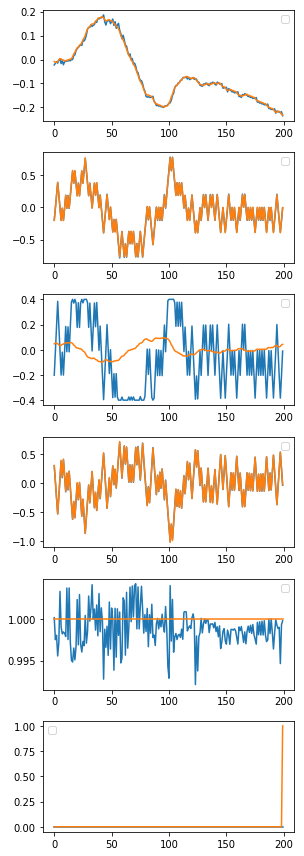

In [18]:
policy.load_model_weights()
dynamics_model.load_model_weights()

policy.eval()
dynamics_model.eval()

%matplotlib inline 
import matplotlib.pyplot as plt 

### Plot the curves of predicted states ### 
### Run one episodes to compare predictions and ground truth ###
s = env.reset()
d = False 
pState = np.zeros((200, 6))
tState = np.zeros((200, 6))
i = 0 
while (not d):
    action = select_action(policy, s)
    nS, r, d, _ = env.step(action)
    tState[i,0] = nS[0]
    tState[i,1] = nS[1]
    tState[i,2] = nS[2]
    tState[i,3] = nS[3]
    tState[i,4] = r 
    tState[i,5] = d*1 

    next_state_p, reward, done = stepModel(policy, s, action)
    state = next_state_p.data.numpy()
    state = state[0]
    reward = reward.data.numpy()[0][0]
    done = done.data.numpy()[0][0]
    done = (done > 0.1)
    
    pState[i,0] = state[0]
    pState[i,1] = state[1]
    pState[i,2] = state[2]
    pState[i,3] = state[3]
    pState[i,4] = reward 
    pState[i,5] = done*1 
    
    s = nS
    i+=1
    print (i)

plt.figure(figsize=(8, 12))
for i in range(6):
    plt.subplot(6, 2, 2*i + 1)
    predicted = plt.plot(pState[:,i], label='Predicted value')
    plt.subplot(6,2,2*i+1)
    true = plt.plot(tState[:,i], label='True value')
    plt.legend([predicted, true], ['Predicted value', 'True value'])
plt.tight_layout()